In [52]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.metrics import cohen_kappa_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics


from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')



### Put presets in place

#### Colorblind-friendly palette

In [ ]:
# Create an array with the colors you want to use
colors = ["#FF0B04", "#4374B3","#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# Set a custom color palette for colour blind readers

# Assign a name to the palette
colorblind1 = sns.set_palette(sns.color_palette(colors)) 


### Import Data

During the EDA phase, we cleaned the data and separated the dataset into two separate dataframes:

X = the independent variables

y = the target variable


In [ ]:
X = pd.read_csv(r'./../data/X.csv') # import the csv file using a relative path to the 'data' folder
X= X.drop(columns=['Unnamed: 0']) # drop index column

X.head()

In [ ]:
y = pd.read_csv(r'./../data/y.csv') # import the csv file using a relative path to the 'data' folder
y= y.drop(columns=['Unnamed: 0']) # drop index column

y.head()

### Examine the class label imbalance

In [ ]:
## Count instances of the target variable 
#count frequencies
counts = y['offer_accepted'].value_counts()
##count and compute as percentage of total 
pct = y['offer_accepted'].value_counts(normalize=True)

#concatenate results into one DataFrame
pd.concat([counts,pct], axis=1, keys=['n', '%'])

Convert the 'Yes' and 'no' values to '1' and '0'

In [ ]:
y['offer_accepted'] = y['offer_accepted'].replace({'No': 0, 'Yes': 1})

In [ ]:
neg, pos = np.bincount(y['offer_accepted'])
total = neg + pos

print('Examples:\n    Total: {}\n    Customers who accepted credit card offer: {} ({:.2f}% of total customer base)\n'.format(
    total, pos, 100 * pos / total))

Before applying our machine learning model to improve the balance between 'Yes' and 'No', we need to scale the numerical variables. 

We'll be using standard scaler to remove the mean and unit variance.

In [ ]:
independents = X.copy() # make a separate df to preserve the column headers

transformer = StandardScaler().fit(independents)
standard_x = transformer.transform(independents)
X = pd.DataFrame(standard_x)
X.columns = independents.columns # put the column headers back
X.head()

#### Optional:

We can plot the data before and after to see if there are any differences.

In [ ]:
sns.pairplot(independents)

In [ ]:
sns.pairplot(X)

In [ ]:
colorblind1 = sns.set_palette(sns.color_palette(colors))

#Create a matrix of panels sharing the same y axis (total claim amount)

fig, axs = plt.subplots(10, 2, figsize=(30, 50)) # width and height 
axs = axs.flatten()
fig.subplots_adjust(hspace=.2, wspace=.2) # ensure that the plots do not overlap


for i, column in enumerate(X.columns):
    sns.histplot(data=X, x=column, palette=sns.color_palette("colorblind"), bins=25, element='step', stat='density', alpha=0.7, ax=axs[i]) # use element='step' to create a histogram-like plot, and stat='density' to normalize the y-axis
    axs[i].set_title(column)

plt.show()


## Training the data

**test_size** =  proportion of the data that should be used for testing. In this case, 30% of the data will be used for testing, while the remaining 70% will be used for training.

**random_state** = is a parameter that sets the random seed, which ensures that the same random split is generated each time the code is run. This is useful for reproducibility.

The function returns four objects:

#### Indepedent variables

*X_train* is a subset of the input dataset containing the independent variables for the training set.


*X_test* is a subset of the input dataset containing the independent variables for the testing set.

#### Dependent variables

*y_train* is a subset of the target variable corresponding to the observations in X_train.

*y_test* is a subset of the target variable corresponding to the observations in X_test.

By splitting the dataset into training and testing sets, we can train a machine learning model on the training set and evaluate its performance on the testing set. This helps to assess the generalization ability of the model, i.e. how well it can predict on new, unseen data.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

classing = LogisticRegression(random_state=0, multi_class = 'ovr').fit(X_train, y_train)
predictions = classing.predict(X_test)

In [ ]:
confusion_matrix(y_test,predictions)

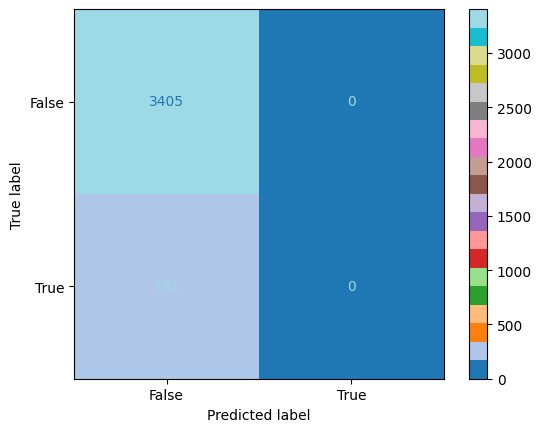

In [55]:

confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap="tab20")



<blockquote style="background-color: #FEECEF; color: #155724; border-color: #FFA0FD; padding: 10px; border-radius: 5px;">
    
**Interpreting the confusion matrix:**
    
_____________

From the above confusion matrix, we can see that we were able to predict:

- **3405 True Negatives (Top-Left Quadrant)**
- O False Positives (Top-Right Quadrant)
- 191 False Negatives (Bottom-Left Quadrant)
- O True Positives (Bottom-Right Quadrant)

This suggests that our model is heavily biased towards true negatives or the 'No', i.e, rejecting the credit card.


    
_____________
</blockquote>